# Task 01 - Práctica

### Librerías

In [30]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt


### Creación del entorno

In [31]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(f"State size: {state_size}, Action size: {action_size}")


State size: 4, Action size: 2


### Creación de las redes

In [32]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

### Hiperparámetros e Instancia de las redes

In [33]:
# hiperparámetros
epsilon = 1.0  # exploración inicial
epsilon_decay = 0.995  # tasa de reducción de epsilon
epsilon_min = 0.01
gamma = 0.95  # factor de descuento
learning_rate = 0.001
batch_size = 64
memory_size = 1000000
target_update_freq = 10
episodes = 500

# Inicializar redes y optimizador
policy_net = DQNetwork(state_size, action_size) # red de linea
target_net = DQNetwork(state_size, action_size) # red de destino
target_net.load_state_dict(policy_net.state_dict())  # Inicializamos con los mismos pesos
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Memoria de experiencia
memory = deque(maxlen=memory_size)

### Épsilon-greedy

In [34]:
def epsilon_greedy_action(state, epsilon):
    if random.random() <= epsilon:
        return random.choice(range(action_size))
    else:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = policy_net(state)
        return torch.argmax(q_values).item()


### Reproducción de la experiencia

In [35]:
def replay_experience(batch_size):
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    
    states, actions, rewards, next_states, dones = zip(*batch)
    
    states = torch.tensor(np.array(states), dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Calculamos Q-valores actuales y el objetivo
    current_q_values = policy_net(states).gather(1, actions)
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]
        target_q_values = rewards + gamma * next_q_values * (1 - dones)
    
    loss = nn.functional.mse_loss(current_q_values.squeeze(), target_q_values)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


### Ciclo de entrenamiento

In [36]:
rewards_list = []

for e in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        
        replay_experience(batch_size)
    
    rewards_list.append(total_reward)
    
    # Actualización de red objetivo
    if e % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    
    # Imprimir progreso
    if e % 10 == 0:
        print(f"Episode {e}, Reward: {total_reward}, Epsilon: {epsilon:.4f}")

# Guardar las recompensas obtenidas
np.save('rewards.npy', rewards_list)


Episode 0, Reward: 18.0, Epsilon: 0.9950
Episode 10, Reward: 34.0, Epsilon: 0.9464
Episode 20, Reward: 40.0, Epsilon: 0.9001
Episode 30, Reward: 42.0, Epsilon: 0.8561
Episode 40, Reward: 31.0, Epsilon: 0.8142
Episode 50, Reward: 15.0, Epsilon: 0.7744
Episode 60, Reward: 11.0, Epsilon: 0.7366
Episode 70, Reward: 37.0, Epsilon: 0.7005
Episode 80, Reward: 108.0, Epsilon: 0.6663
Episode 90, Reward: 45.0, Epsilon: 0.6337
Episode 100, Reward: 62.0, Epsilon: 0.6027
Episode 110, Reward: 35.0, Epsilon: 0.5733
Episode 120, Reward: 9.0, Epsilon: 0.5452
Episode 130, Reward: 147.0, Epsilon: 0.5186
Episode 140, Reward: 203.0, Epsilon: 0.4932
Episode 150, Reward: 23.0, Epsilon: 0.4691
Episode 160, Reward: 201.0, Epsilon: 0.4462
Episode 170, Reward: 188.0, Epsilon: 0.4244
Episode 180, Reward: 202.0, Epsilon: 0.4036
Episode 190, Reward: 14.0, Epsilon: 0.3839
Episode 200, Reward: 68.0, Epsilon: 0.3651
Episode 210, Reward: 60.0, Epsilon: 0.3473
Episode 220, Reward: 217.0, Epsilon: 0.3303
Episode 230, Rew

### Visualización del progreso del agente

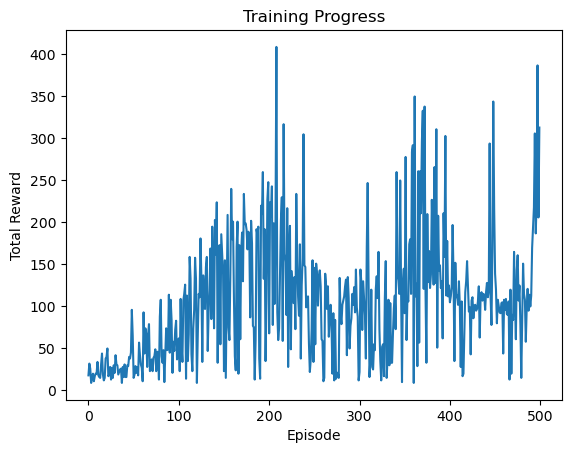

In [37]:
plt.plot(rewards_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

### Evaluación del rendimiento del agente

In [38]:
# Initialize the environment with render_mode
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0
while not done:
    action = epsilon_greedy_action(state, epsilon_min)  # Usamos una política greedy
    next_state, reward, done, _, _ = env.step(action)
    env.render()
    state = next_state
    total_reward += reward
env.close()
print(f"Total Reward: {total_reward}")

### Fine tunning

In [39]:
env.close()

# Parámetros iniciales para ajustar
learning_rates = [0.001, 0.0005]
gammas = [0.95, 0.99]
epsilons = [1.0]
epsilon_decays = [0.995, 0.99]
target_update_frequencies = [5, 10]
batch_sizes = [32, 64]

# Guardar las mejores configuraciones
best_config = None
best_avg_reward = -float('inf')

# Bucle para experimentar con diferentes combinaciones de hiperparámetros
for lr in learning_rates:
    for gamma in gammas:
        for eps_decay in epsilon_decays:
            for target_update_freq in target_update_frequencies:
                for batch_size in batch_sizes:
                    print(f"Evaluando con: LR={lr}, Gamma={gamma}, Epsilon Decay={eps_decay}, Update Freq={target_update_freq}, Batch Size={batch_size}")
                    
                    # Reiniciar el entorno y las redes
                    policy_net = DQNetwork(state_size, action_size)
                    target_net = DQNetwork(state_size, action_size)
                    target_net.load_state_dict(policy_net.state_dict())
                    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
                    memory = deque(maxlen=memory_size)
                    epsilon = 1.0
                    rewards_list = []
                    
                    # Entrenar el agente
                    for e in range(episodes):
                        state, _ = env.reset()  # Reinicia el entorno
                        total_reward = 0
                        done = False
                        while not done:
                            action = epsilon_greedy_action(state, epsilon)
                            next_state, reward, done, _, _ = env.step(action)
                            memory.append((state, action, reward, next_state, done))
                            state = next_state
                            total_reward += reward
                            replay_experience(batch_size)
                        
                        rewards_list.append(total_reward)
                        if e % target_update_freq == 0:
                            target_net.load_state_dict(policy_net.state_dict())
                        if epsilon > epsilon_min:
                            epsilon *= eps_decay

                    # Cerrar el entorno después del episodio
                    env.close()
                    
                    # Calcular el promedio de recompensas de los últimos 50 episodios
                    avg_reward = np.mean(rewards_list[-50:])
                    print(f"Avg Reward: {avg_reward}")
                    
                    # Guardar la mejor configuración
                    if avg_reward > best_avg_reward:
                        best_avg_reward = avg_reward
                        best_config = {
                            'learning_rate': lr,
                            'gamma': gamma,
                            'epsilon_decay': eps_decay,
                            'target_update_freq': target_update_freq,
                            'batch_size': batch_size,
                            'average_reward': avg_reward
                        }

print(f"Mejor configuración encontrada: {best_config}")


Evaluando con: LR=0.001, Gamma=0.95, Epsilon Decay=0.995, Update Freq=5, Batch Size=32
Avg Reward: 137.24
Evaluando con: LR=0.001, Gamma=0.95, Epsilon Decay=0.995, Update Freq=5, Batch Size=64
Avg Reward: 132.1
Evaluando con: LR=0.001, Gamma=0.95, Epsilon Decay=0.995, Update Freq=10, Batch Size=32
Avg Reward: 145.06
Evaluando con: LR=0.001, Gamma=0.95, Epsilon Decay=0.995, Update Freq=10, Batch Size=64
Avg Reward: 178.3
Evaluando con: LR=0.001, Gamma=0.95, Epsilon Decay=0.99, Update Freq=5, Batch Size=32
Avg Reward: 211.38
Evaluando con: LR=0.001, Gamma=0.95, Epsilon Decay=0.99, Update Freq=5, Batch Size=64
Avg Reward: 569.1
Evaluando con: LR=0.001, Gamma=0.95, Epsilon Decay=0.99, Update Freq=10, Batch Size=32
Avg Reward: 159.62
Evaluando con: LR=0.001, Gamma=0.95, Epsilon Decay=0.99, Update Freq=10, Batch Size=64
Avg Reward: 262.18
Evaluando con: LR=0.001, Gamma=0.99, Epsilon Decay=0.995, Update Freq=5, Batch Size=32
Avg Reward: 97.38
Evaluando con: LR=0.001, Gamma=0.99, Epsilon Decay

# Task 2

Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en Deep Reinforcement Learning

**1. Proximal Policy Optimization (PPO)** <br>

PPO es un algoritmo de Deep Reinforcement Learning perteneciente a la familia de métodos basados en políticas .Es una mejor de los métodos de gradiente de política y se usa para aprender una política que maximiza las recompensa esperada a largo plazo. Funciona de la siguiente manera: PPO busca actualizar la política sin realizar cambios abruptos, buscando no desestabilizar el aprendizaje. 

Características:
- Usa la razón de probabilidad entre la política nueva y la antigua para limitar el cambio en la política, con una restricción de confianza. 
- Maximiza una función objetivo que combina el gradiente de políticai y la penalización de grandes cambios. 

Problemas en los que se puede usar:
- Problemas de control continuo o discreto. 
- Tareas de navegación autónoma.
- Juegos de Atari.
- Entornos donde hay alta dimensionalidad en los estados y acciones.
- Entornos donde hay alta incertidumbre. 

**2. Deep Deterministic Policy Gradient (DDPG)** 

Es un algoritmo de Deep Reinforcement Learning basado en políticas que extiende el menfoque de Deterministic POlicy Gradient usando redes neuronales profundas. Es un método actor-critic que aprende una política determinista.

Características:
- El actor aprende una política determinística que selecciona acciones directamente a partir de los estados, sin muestreo.
- El crítico estima el valor Q de la política determinística aprendida por el actor.
- Usa técnicas de estabilización como experiencia replay y target networks.

Problemas en los que se puede usar:
- Problemas de control continuo.
- Tareas de navegación autónoma.
- Manipulación de objetos.

**3. Trust Region Policy Optimization (TRPO)**

Es un algoritmo de DRL basado en políticas. Está diseñado para garantizar actualizaciones de políticas mas estables y eficientes en el aprendizaje por una política óptima. TRPO ajusta la política gradualmente para evitar grandes cambios que puedan reducir el rendimiento, de manera que se asegure que cada actualización esté dentro de una región de confianza previamente definida. 

Características:

- Restringe la magnitud de los cambios en la política usando una métrica llamada divergencia de Kullback-Leibler (KL), que mide cuán diferente es la nueva política respecto a la anterior.
- Optimiza la política directamente, lo que lo hace adecuado para entornos de espacio continuo y discretos.
- Es más estable que los métodos de gradiente de política tradicionales, pero computacionalmente más costoso.

Problemas en los que se utiliza:

- Robótica y sistemas físicos donde los cambios abruptos pueden ser perjudiciales.
- Videojuegos complejos (como juegos de Atari) y simulaciones donde se necesita alta estabilidad en las actualizaciones de políticas.
- Tareas de control continuo como navegación, control de drones o vehículos autónomos.

**4. Asynchronous Advantage Actor-Critic (A3C)**

Es un algoritmo de Deep Reinforcement Learning que combina el enfoque actor-crítico con el aprendizaje asincrónico. A3C aprovecha múltiples agentes o hilos que interactúan con el entorno de manera independiente, aprendiendo en paralelo y actualizando la política global de forma asincrónica.

Características:

- Utiliza un actor que aprende la política (selección de acciones) y un crítico que estima el valor esperado (ventaja) de las acciones.
- Los hilos ejecutan copias independientes del entorno, actualizando una política global compartida.
- Calcula la ventaja (Advantage) para medir cuán buena fue una acción en comparación con lo esperado, mejorando la eficiencia del aprendizaje.
- Asincronía permite una exploración más diversa, evitando quedarse atrapado en subóptimos locales.


Problemas en los que se utiliza:

- Problemas de aprendizaje en paralelo y alta dimensionalidad, como en juegos complejos (e.g., Atari, StarCraft).
- Tareas de control continuo y ambientes físicos donde se necesita eficiencia computacional (robots, simulaciones físicas).
- Es adecuado para problemas que requieren alta exploración y eficiencia, como entornos de simulación masiva o multi-agente.